In [1]:
import warnings
warnings.filterwarnings('ignore')

import random, re, time, xgboost
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#맷플랏립 그래프 주피터에서 바로 출력하기
from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

from scipy import stats
from scipy.stats import t, norm, chi2, chi2_contingency, skew
from sklearn.datasets import load_iris, make_classification, load_breast_cancer, load_boston
from sklearn import datasets, tree

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Binarizer, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report, precision_recall_curve, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import plot_importance, XGBClassifier, XGBRegressor

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

## 차원 축소
* 매우 많은 피처로 구성된 다차원 데이터 세트의 차원을 축소해 새로운 차원의 데이터 세트를 생성하는 것
* 차원이 증가할 수록 데이터 포인트 간의 거리가 기하급수적으로 멀어지게 되고 희소한 구조를 가지며 예측 신뢰도가 떨어짐
* 선형 모델에서는 입력 변수 간의 상관관계가 높을 경우 다중 공선성 문제로 모델의 예측 성능 저하
* 다차원의 피처를 차원 축소해 피처 수를 줄이면 더 직관적으로 데이터를 해석할 수 있음
* 차원 축소는 피처 선택과 피처 추출로 나눌 수 있음
* 피처 선택은 특정 피처에 종속성이 강한 불필요한 피처는 제거하고 데이터의 특징을 잘 나타내는 주요 피처만 선택
* 피처 추출은 기존 피처를 저차원의 중요 피처로 압축해서 추출. 기존의 피처가 압축된 것이므로 기존 피처와는 다른 값이 됨
* 차원 축소를 통해 좀 더 데이터를 잘 설명할 수 있는 잠재적인 요소를 추출하며 PCA, SVD, NMF은 대표적인 차원 축소 알고리즘

입력 데이터의 공분산 행렬을 고유벡터와 고유값으로 분해하는 과정은 선형 대수학의 핵심 개념 중 하나이며, 주성분 분석(PCA) 같은 데이터 분석 기법에서 자주 사용됩니다. 이러한 과정을 이해하려면, 우선 공분산 행렬, 고유벡터, 고유값이 무엇인지 이해해야 합니다.


- 행렬을 사용하여 변환(스케일링, 회전 등)을 수행할 수 있습니다. 이 변환 과정에서 변환된 결과가 원래 벡터의 스칼라 배만큼 변하는 벡터가 있을 수 있는데, 이를 '고유벡터'라고 합니다. 즉, 행렬에 의한 변환을 받아도 방향이 바뀌지 않고 크기만 변하는 벡터를 고유벡터라고 합니다.

- 이때 그 벡터가 얼마나 스케일링되는지, 즉 얼마나 크기가 변하는지를 나타내는 스칼라 값을 '고유값'이라고 합니다.

- 위의 설명을 수식 Ax = λx로 매핑해볼 수 있습니다. 여기서 A는 변환을 나타내는 행렬, x는 고유벡터, λ는 고유값입니다. 이 수식은 "행렬 A에 의해 벡터 x가 변환되면, 그 결과는 원래의 벡터 x의 λ배만큼 크기가 변한 벡터"라는 의미를 가지고 있습니다.

- 고유벡터와 고유값을 찾는 것은, 주어진 행렬의 변환에 대하여 방향은 유지하면서 크기만 변하는 벡터와 그 변화의 크기를 찾는 것입니다.

#### 선형대수식
* 크기와 방향을 가지고 있는 것을 vector, 반면 크기만 있는 것(질량, 온도, 길이)을 scalar이라고 한다
* 고유벡터 : 행렬 A를 곱하더라도 방향이 변하지 않고 그 크기만 변하는 벡터 Ax = ax(A 행렬, x 고유벡터, a 스칼라)
* 고유값(Eigenvalue) : 고유 벡터의 크기. 입력데이터의 분산
* 선형 변환 : 특정 벡터에 행렬  A를 곱해 새로운 벡터로 변환
* 공분산 행렬 : 두변수간의 변동을 의미. 공분산 Cov(X,Y) > 0 은 X가 증가할 때 Y도 증가
* 대칭행렬 : 고유벡터를 항상 직교행렬로 고유값을 정방 행렬로 대각화할 수 있음
* 직교행렬 : 대각원소 이외의 모든 원소가 0일때. 직교행렬의 역행렬은 직교행렬 자신의 전치행렬과 같음

In [3]:
# 대칭행렬(Symmetric Matrix)은 그 이름에서 알 수 있듯이, 대각선을 기준으로 각 원소가 대칭적으로 
# 배치된 행렬. 즉, 행렬의 i행 j열 원소와 j행 i열 원소가 동일한 경우, 이 행렬은 대칭행렬
import numpy as np

A = np.array([[1, 2, 3], [2, 4, 5], [3, 5, 6]])
print(A)

[[1 2 3]
 [2 4 5]
 [3 5 6]]


In [4]:
# 직교행렬(Orthogonal Matrix)은 그 자신과 자신의 전치행렬(행과 열이 바뀐 행렬)을 곱하면 
# 단위행렬(대각선 원소만 1이고 나머지 원소는 모두 0인 행렬)이 되는 행렬. 이는 행렬의 모든 행 벡터들이 
# 서로 직교(즉, 내적이 0)하고, 각 행 벡터의 크기가 1이라는 것을 의미합니다. 이러한 성질로 인해 직교행렬의 
# 역행렬은 그 자신의 전치행렬과 같다.

O = np.array([[1,0],[0,1]])
print(O,'\n')
print(O.T,'\n')
print(np.dot(O, O.T),'\n')
O_inv = np.linalg.inv(O)
print(O_inv,'\n')

print(np.dot(O, O_inv))

[[1 0]
 [0 1]] 

[[1 0]
 [0 1]] 

[[1 0]
 [0 1]] 

[[1. 0.]
 [0. 1.]] 

[[1. 0.]
 [0. 1.]]


In [5]:
# Q. 역행렬 구하고 행렬x역행렬 = 단위행렬 검증하세요
import numpy as np

# 원래의 행렬 A 정의
A = np.array([[1, 2], [3, 4]])

# A의 역행렬을 구함
A_inv = np.linalg.inv(A)

print("행렬 A:")
print(A)

print("\n행렬 A의 역행렬:")
print(A_inv)

# 검증: A와 A의 역행렬을 곱하면 단위행렬이 나와야 함
print("\n검증: A와 A의 역행렬을 곱함:")
print(np.dot(A, A_inv))

행렬 A:
[[1 2]
 [3 4]]

행렬 A의 역행렬:
[[-2.   1. ]
 [ 1.5 -0.5]]

검증: A와 A의 역행렬을 곱함:
[[1.0000000e+00 0.0000000e+00]
 [8.8817842e-16 1.0000000e+00]]


In [6]:
# 대칭행렬은 그 자신의 전치행렬과 같은 행렬
import numpy as np

# 임의의 행렬 생성
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(A,'\n')
# 대칭행렬 생성
symmetric_matrix = (A + A.T) / 2
print(symmetric_matrix)

[[1 2 3]
 [4 5 6]
 [7 8 9]] 

[[1. 3. 5.]
 [3. 5. 7.]
 [5. 7. 9.]]


In [7]:
# 고유값과 고유벡터 계산
eigval, eigvec = np.linalg.eig(symmetric_matrix)

# 결과 출력
print("Eigenvalues:", eigval)
print("Eigenvectors:\n", eigvec)

Eigenvalues: [ 1.64582364e+01 -1.45823643e+00  1.62591776e-16]
Eigenvectors:
 [[-0.35162514 -0.84243284  0.40824829]
 [-0.55335618 -0.1647127  -0.81649658]
 [-0.75508721  0.51300744  0.40824829]]


#### 행렬 분해
- 공분산 행렬은 여러 변수간의 공분산을 행렬 형태로 나타낸 것입니다. 대각선 원소는 각 변수의 분산을 나타내고, 비대각선 원소는 서로 다른 두 변수간의 공분산을 나타냅니다.
- 공분산 행렬을 고유벡터와 고유값으로 분해하는 과정은 대략적으로 다음과 같습니다.

    - 입력 데이터로부터 공분산 행렬을 계산합니다.
    - 계산된 공분산 행렬에 대해 고유값과 고유벡터를 찾습니다. 이를 위해 보통 행렬 대수학에서 사용하는 기법들을 활용합니다.
    - 고유값을 내림차순으로 정렬하고, 해당 고유값에 대응되는 고유벡터도 같은 순서로 정렬합니다. 이 때, 각 고유벡터는 서로 직교(orthogonal)합니다.
    - 최종적으로 고유값과 고유벡터는 원래의 공분산 행렬을 재구성하는 데 사용됩니다.

이 과정을 통해, 데이터의 공분산 행렬은 그 행렬을 이루는 벡터공간에 대한 정보, 즉, 고유벡터(방향)와 고유값(크기)을 추출할 수 있게 됩니다. 이는 데이터의 차원 축소, 노이즈 제거, 특성 추출 등 다양한 분석에 사용되는 기법입니다.

In [8]:
# 행 벡터들이 직교하면 내적은 0
import numpy as np

# 임의의 데이터 셋 생성
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(data,'\n')

# 1. 공분산 행렬 계산
cov_mat = np.cov(data.T)  # np.cov는 각 변수(여기서는 각 열)의 쌍에 대한 공분산을 계산
print(cov_mat,'\n')

# 2. 고유값과 고유벡터 계산
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print(eig_vals,'\n')
print(eig_vecs,'\n')

# 3. 고유값 정렬 및 해당하는 고유벡터 매칭
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0],i[1])

# 각 고유벡터가 직교하는지 확인. 내적 0
print('\nOrthogonality check:')
print(np.dot(eig_vecs[:,0], eig_vecs[:,1]))


[[1 2 3]
 [4 5 6]
 [7 8 9]] 

[[9. 9. 9.]
 [9. 9. 9.]
 [9. 9. 9.]] 

[ 0. 27.  0.] 

[[-0.81649658  0.57735027  0.        ]
 [ 0.40824829  0.57735027 -0.70710678]
 [ 0.40824829  0.57735027  0.70710678]] 

Eigenvalues in descending order:
27.000000000000007 [0.57735027 0.57735027 0.57735027]
0.0 [-0.81649658  0.40824829  0.40824829]
0.0 [ 0.         -0.70710678  0.70710678]

Orthogonality check:
1.1102230246251565e-16


In [9]:
import numpy as np

# 임의의 행렬 생성
A = np.array([[4, 2], [1, 3]])

# 고유값과 고유벡터 계산
# np.linalg.inv 함수는 행렬의 역행렬을 계산
eig_vals, eig_vecs = np.linalg.eig(A)

# 고유값을 대각행렬로 변환
eig_val_mat = np.diag(eig_vals)

# 복구 과정
# V * Λ * V^-1  (여기서 V는 고유벡터 행렬, Λ는 고유값 대각행렬)
A_reconstructed = eig_vecs @ eig_val_mat @ np.linalg.inv(eig_vecs)

print("Original matrix:")
print(A)

print("\nReconstructed matrix from eigendecomposition:")
print(A_reconstructed)


Original matrix:
[[4 2]
 [1 3]]

Reconstructed matrix from eigendecomposition:
[[4. 2.]
 [1. 3.]]


### PCA
* 입력 데이터의 공분산 행렬이 고유벡터와 고유값으로 분해될 수 있으며 이렇게 분해된 고유벡터을 이용해 입력 데이터를 선형 변환하는 방식이 PCA
* 입력 데이터 세트의 공분산 행렬을 생성
* 공분산 행렬의 고유벡터와 고유값을 계산
* 고유값이 가장 큰 순으로 K개(PCA 변환 차수)만큼 고유벡터를 추출
* 고유값이 가장 큰 순으로 추출되며 고유벡터를 이용해 새롭게 입력 데이터을 변환

### LDA(Linear Discriminant Analysis)
* PCA와 매우 유사한 방식이며 PCA가 입력 데이터 변동성의 가장 큰 축을 찾는데 반해 LDA는 입력 데이터의 결정 값 클래스를 최대한으로 분리할 수 있는 축을 찾는 방식으로 차원을 축소

### SVD, NMF
* 매우 많은 피처 데이터를 가진 고차원 행렬을 두 개의 저차원 행렬로 분리하는 행렬 분해 기법.
* 행렬 분해를 수행하면서 원본 행렬에서 잠재된 요소를 추출하기 때문에 토픽 모델이나 추천 시스템에서 활발하게 사용 

### PCA

In [10]:
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 사이킷런 내장 데이터 셋 API 호출
iris = load_iris()

# 넘파이 데이터 셋을 Pandas DataFrame으로 변환
columns = ['sepal_length','sepal_width','petal_length','petal_width']
irisDF = pd.DataFrame(iris.data , columns=columns)
irisDF['target']=iris.target
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


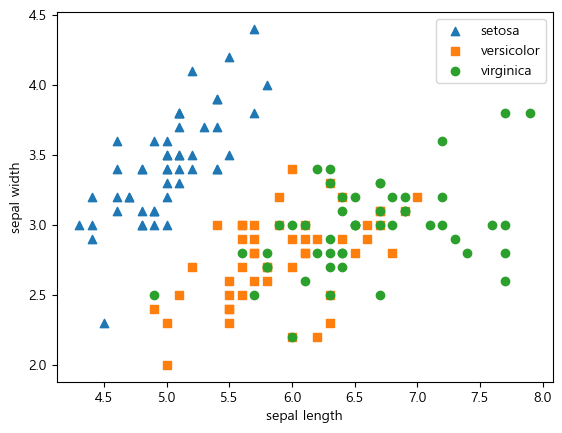

In [11]:
#setosa는 세모, versicolor는 네모, virginica는 동그라미로 표현
markers=['^', 's', 'o']

#setosa의 target 값은 0, versicolor는 1, virginica는 2. 각 target 별로 다른 shape으로 scatter plot 
for i, marker in enumerate(markers):
    x_axis_data = irisDF[irisDF['target']==i]['sepal_length']
    y_axis_data = irisDF[irisDF['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler

# Target 값을 제외한 모든 속성 값을 StandardScaler를 이용하여 표준 정규 분포를 가지는 값들로 변환
iris_scaled = StandardScaler().fit_transform(irisDF.iloc[:, :-1])

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)
print(iris_pca.shape)

(150, 2)


In [14]:
# PCA 변환된 데이터의 컬럼명을 각각 pca_component_1, pca_component_2로 명명
pca_columns=['pca_component_1','pca_component_2']
irisDF_pca = pd.DataFrame(iris_pca, columns=pca_columns)
irisDF_pca['target']=iris.target
irisDF_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


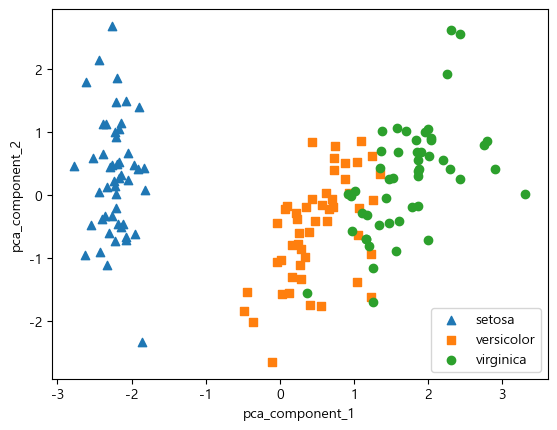

In [15]:
#setosa를 세모, versicolor를 네모, virginica를 동그라미로 표시
markers=['^', 's', 'o']

#pca_component_1 을 x축, pc_component_2를 y축으로 scatter plot 수행. 
for i, marker in enumerate(markers):
    x_axis_data = irisDF_pca[irisDF_pca['target']==i]['pca_component_1']
    y_axis_data = irisDF_pca[irisDF_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

In [16]:
print(pca.explained_variance_ratio_)

[0.72962445 0.22850762]


#### [과제] iris data 원본과 차원축소 데이터에 대하여 각각 모델링(rf) 및 평가(교차검증)한 후 결과를 비교하세요.

In [17]:
# pca가 더 잘 안 나옴(차원을 축소했기 때문에, 전체보단 덜 나오는 것)
# 대신 경우에 따라 여러 문제를 해결해줌(ex.다중성, 작업 코스트 감소 등)

In [18]:
rf = RandomForestClassifier(random_state=156)
scores = cross_val_score(rf, iris.data, iris.target, scoring='accuracy', cv=3)
print(f'원본 데이터 교차검증 개별 정확도: {scores}')
print(f'원본 데이터 평균 정확도: {np.mean(scores)}')

원본 데이터 교차검증 개별 정확도: [0.98 0.94 0.96]
원본 데이터 평균 정확도: 0.96


In [19]:
pca_x = irisDF_pca[['pca_component_1', 'pca_component_2']]
scores_pca = cross_val_score(rf, pca_x, iris.target, scoring='accuracy', cv=3)
print(f'원본 데이터 교차검증 개별 정확도: {scores_pca}')
print(f'원본 데이터 평균 정확도: {np.mean(scores_pca)}')

원본 데이터 교차검증 개별 정확도: [0.88 0.88 0.88]
원본 데이터 평균 정확도: 0.88


In [20]:
df = pd.read_excel(r'D:\hmkd1\m1_programming\[8] 머신러닝\credit_card.xls', 
            header=1, sheet_name='Data')    # 신용카드 데이터셋
df.drop('ID', axis=1, inplace=True)   #인덱스와 겹치므로 id 삭제
df.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'default'}, inplace=True)

print(df.shape)
df.head(3)

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [21]:
xdf = df.drop('default', axis=1)
ydf = df.default    #타겟값 (1=연체, 0=정상납부)

<AxesSubplot:>

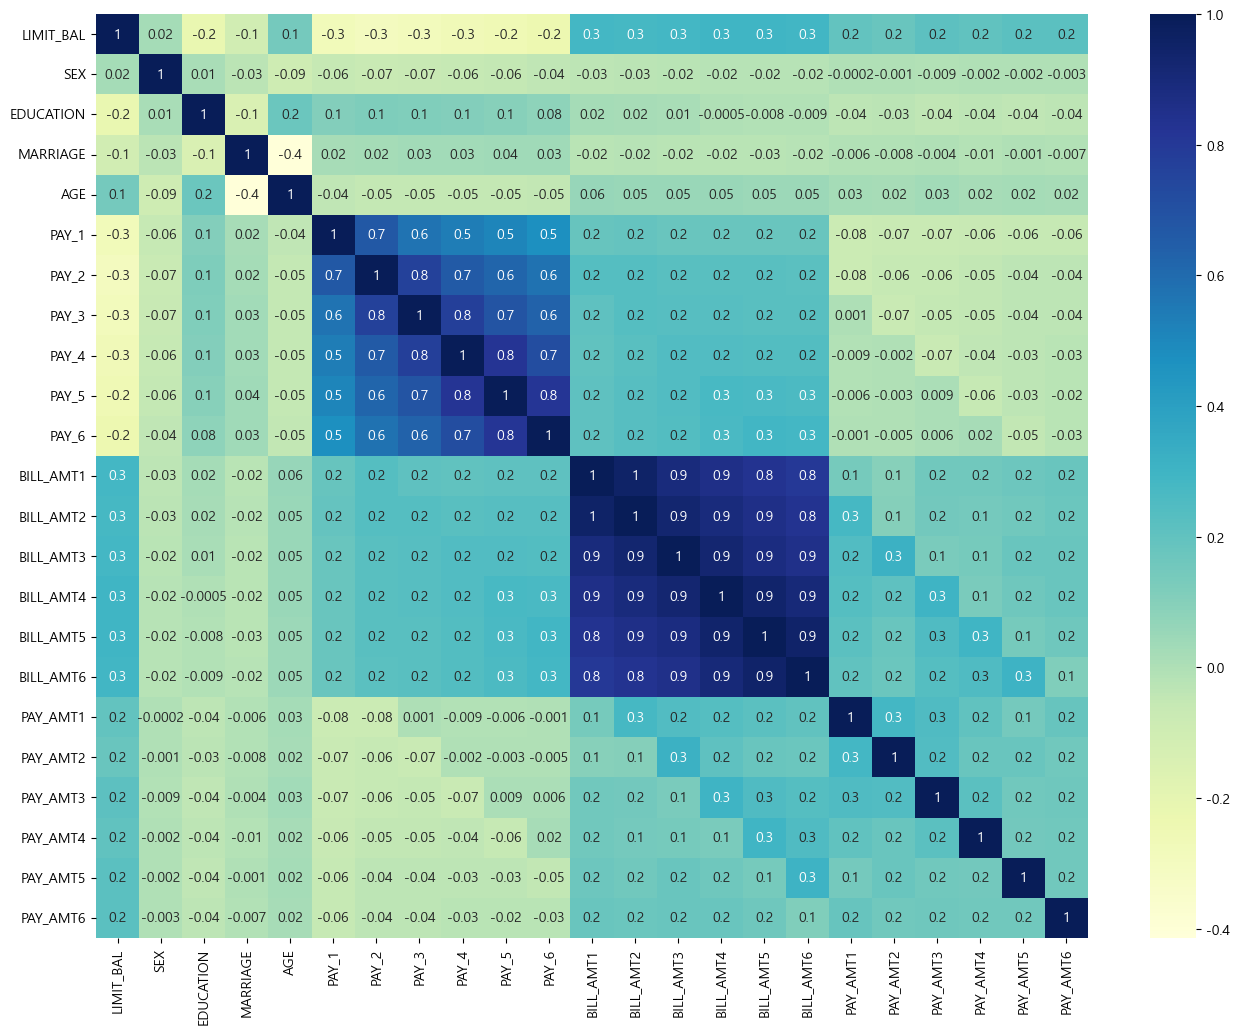

In [22]:
corr = xdf.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, fmt='.1g', cmap='YlGnBu')

### 다중공선성
- 다중 회귀모델에서 두개 이상의 독립변수가 높은 상관 관계가 있는 경우에 발생
- 부정적인 문제를 발생시킴
    - 회귀계수의 불안정하고 신뢰할 수 없는 추정치 초래
    - 회귀계수의 분산을 팽창시켜 모델의 사소한 변화에 민감하게 만듬
    - 모델을 해석하기 어렵게 함. 한 변수의 효과가 다른 상관관계의 효과 뒤에 숨겨져 있어 예상치 못한 양의 부호를 가질 수 있음
- 다중공선성을 검출하는 방법
    - 상관관계가 -1 또는 1에 가까울 수록 다중공선성이 높음
    - VIF(Variance inflation factor), 분산팽창지수는 다중공선성으로 인해 추정된 회귀계수의 분산이 얼마나 증가하는지를 측정

In [23]:
bills = ['BILL_AMT'+str(n) for n in range(1,7)]
# pays = ['PAY_'+str(n) for n in range(1,7)]
# amts = ['PAY_AMT'+str(n) for n in range(1,7)]
# bills.extend(pays)   #확장(리스트 뒤에 붙여넣기)
# bills.extend(amts)
print(f'bills 리스트: {bills}\n')   #전부 한 리스트로 만듬

scaler = StandardScaler()   #객체 생성
df_bill_scaled = scaler.fit_transform(xdf[bills])    #정규화
xdf.loc[:, bills] = df_bill_scaled    # xdf에 반영

pca = PCA(n_components=2)   #주성분 2개
pca.fit(df_bill_scaled)
print(f'PCA Components별 변동성: {pca.explained_variance_ratio_}')
# pca.explained_variance_ratio_: 주성분 분석(PCA)에서 
# 각 주성분이 전체 분산에서 설명하는 비율(%)을 나타내는 속성(배열 형태)

bills 리스트: ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

PCA Components별 변동성: [0.90555253 0.0509867 ]


In [24]:
# 원본 데이터 모델링 & 평가
rf = RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rf, xdf, ydf, scoring='accuracy', cv=3)

print(f'cv=3인 경우 개별 폴드 세트별 정확도: {scores}')
print(f'평균 정확도: {np.mean(scores):.4f}')

cv=3인 경우 개별 폴드 세트별 정확도: [0.8083 0.8196 0.8232]
평균 정확도: 0.8170


In [25]:
# 6개 PCA 컴포넌트 모델링 & 평가
# 원본(24개)의 1/4 수준(6개)으로 1~2% 정도의 성능 저하 -> 뛰어난 압축 눙력
scaler = StandardScaler()
df_scaled = scaler.fit_transform(xdf)

pca = PCA(n_components=6)   #주성분 6개
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rf, df_pca, ydf, scoring='accuracy', cv=3)

print(f'cv=3인 경우 PCA 변환된 개별 폴드 세트별 정확도: {scores_pca}')
print(f'평균 정확도: {np.mean(scores_pca):.4f}')

KeyboardInterrupt: 

PCA(Principal Component Analysis)는 공분산 행렬(covariance matrix)을 기반으로 하는 차원 축소 기법입니다. 공분산은 두 변수 간의 관계 및 분산을 나타내는 통계적 개념입니다. PCA는 데이터의 주성분을 추출하기 위해 주어진 데이터의 공분산 행렬을 분석합니다.

공분산은 두 변수 간의 관계를 측정하는 동시에 각 변수의 분산을 고려합니다. 양의 공분산은 변수들이 함께 증가하거나 감소하는 경향을 나타내며, 음의 공분산은 변수들이 반대로 움직이는 경향을 나타냅니다. 공분산 행렬은 변수 간의 모든 공분산 값을 포함한 정방행렬입니다.

PCA는 데이터의 분산을 최대화하는 새로운 축을 찾아내는데, 이 새로운 축들은 데이터의 원래 변수들과 관련된 선형 조합으로 표현됩니다. 이 때, 공분산 행렬을 분석하여 이 새로운 축들을 결정합니다. 공분산 행렬의 고유값(eigenvalue)과 고유벡터(eigenvector)를 계산하여 주성분을 구할 수 있습니다.

PCA를 수행하면 공분산 행렬의 고유값과 고유벡터를 계산하고, 고유값에 따라 주성분을 정렬하여 차원을 축소할 수 있습니다. 이를 통해 데이터의 정보를 가장 많이 보존하는 주성분을 선택할 수 있습니다.



- 공분산의 변동성을 기준으로 함


### LDA(선형 판별 분석)

In [26]:
iris = load_iris()
iris_scaled = StandardScaler().fit_transform(iris.data)

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)    #2개로 변환
lda.fit(iris_scaled, iris.target)
iris_lda = lda.transform(iris_scaled)

print(iris_lda.shape)

(150, 2)


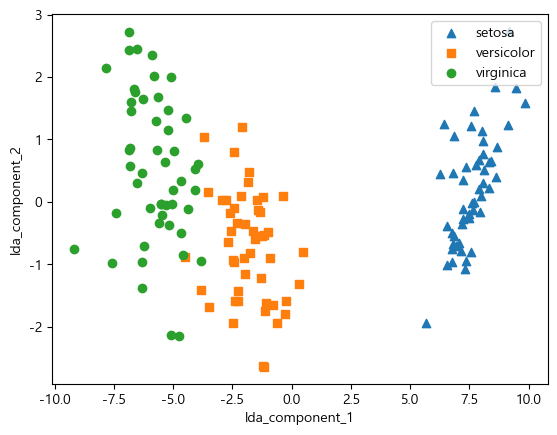

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

lda_columns=['lda_component_1','lda_component_2']
irisDF_lda = pd.DataFrame(iris_lda,columns=lda_columns)
irisDF_lda['target']=iris.target

#setosa는 세모, versicolor는 네모, virginica는 동그라미로 표현
markers=['^', 's', 'o']

#setosa의 target 값은 0, versicolor는 1, virginica는 2. 각 target 별로 다른 shape으로 scatter plot
for i, marker in enumerate(markers):
    x_axis_data = irisDF_lda[irisDF_lda['target']==i]['lda_component_1']
    y_axis_data = irisDF_lda[irisDF_lda['target']==i]['lda_component_2']

    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend(loc='upper right')
plt.xlabel('lda_component_1')
plt.ylabel('lda_component_2')
plt.show()

Explained variance ratios: [0.9912126 0.0087874]


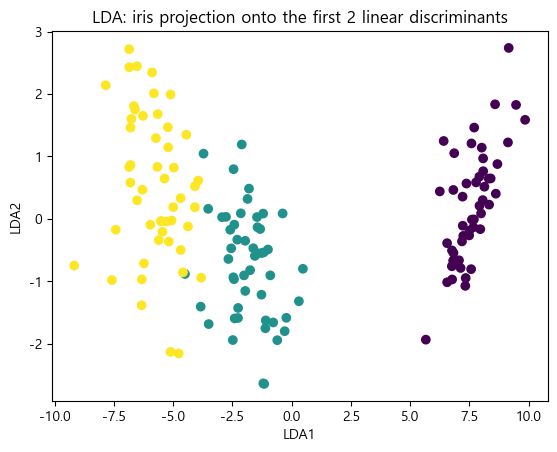

In [29]:
iris = load_iris()
x = iris.data
y = iris.target

lda = LinearDiscriminantAnalysis(n_components=2)
x_lda = lda.fit_transform(x,y)
print(f'Explained variance ratios: {lda.explained_variance_ratio_}')

plt.scatter(x_lda[:,0], x_lda[:, 1], c=y)

plt.xlabel('LDA1'); plt.ylabel('LDA2')
plt.title('LDA: iris projection onto the first 2 linear discriminants')
plt.show()

### SVD

In [30]:
np.random.seed(121)
a = np.random.randn(4,4)
print(np.round(a,3))

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]


In [31]:
from numpy.linalg import svd
U, Sigma, Vt = svd(a)    #U, Vt의 백터는 특이벡터, Sigma는 대각행렬
print(U.shape, Sigma.shape, Vt.shape)
print(f'U matrix: {np.round(U,3)}\n')
print(f'Sigma matrix: {np.round(Sigma,3)}\n')
print(f'Vt matrix: {np.round(Vt,3)}')

(4, 4) (4,) (4, 4)
U matrix: [[-0.079 -0.318  0.867  0.376]
 [ 0.383  0.787  0.12   0.469]
 [ 0.656  0.022  0.357 -0.664]
 [ 0.645 -0.529 -0.328  0.444]]

Sigma matrix: [3.423 2.023 0.463 0.079]

Vt matrix: [[ 0.041  0.224  0.786 -0.574]
 [-0.2    0.562  0.37   0.712]
 [-0.778  0.395 -0.333 -0.357]
 [-0.593 -0.692  0.366  0.189]]


- 대칭행렬: 대각선을 기준으로 대칭
- 대각행렬: 대각선을 제외한 나머지가 전부 0
    - 대각행렬은 대칭행렬의 부분집합. 
    - 즉, 모든 대각행렬은 대칭이지만, 모든 대칭행렬이 대각행렬은 아님

In [32]:
Sigma_mat = np.diag(Sigma)   #시그마를 다시 0을 포함한 대각행렬로 반환
print(Sigma_mat, '\n')

a_ = np.dot(np.dot(U, Sigma_mat), Vt)   #행렬곱
print(np.round(a_, 3))   #원본 행렬(a)이랑 같아짐

[[3.4229581  0.         0.         0.        ]
 [0.         2.02287339 0.         0.        ]
 [0.         0.         0.46263157 0.        ]
 [0.         0.         0.         0.07935069]] 

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]


In [33]:
a[2] = a[0]+a[1]
a[3] = a[0]
print(np.round(a,3))

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.542  0.899  1.041 -0.073]
 [-0.212 -0.285 -0.574 -0.44 ]]


In [34]:
# 다시 SVD를 수행하여 시그마값 확인
# 선형 독립인 로우 벡터의 개수가 2개라는 의미
U, Sigma, Vt = svd(a)
print(U.shape, Sigma.shape, Vt.shape)
print(f'Sigma value: {np.round(Sigma,3)}')

(4, 4) (4,) (4, 4)
Sigma value: [2.663 0.807 0.    0.   ]


In [35]:
# U행렬의 경우는 Sigma와 내적을 수행하므로 
# Sigma의 앞 2행에 대응되는 앞 2열만 추출
U_ = U[:, :2]
Sigma_ = np.diag(Sigma[:2])

# V전치 행렬의 경우는 앞 2행만 추출
Vt_ = Vt[:2]
print(U_.shape, Sigma_.shape, Vt_.shape, '\n')

# U, Sigma, Vt의 내적을 수행하며, 다시 원본 행렬 복원
a_ = np.dot(np.dot(U_, Sigma_), Vt_)
print(np.round(a_, 3))

(4, 2) (2, 2) (2, 4) 

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.542  0.899  1.041 -0.073]
 [-0.212 -0.285 -0.574 -0.44 ]]


#### 과제[1]: Truncated SVD를 이용한 행렬 분해

In [36]:
#Truncated SVD: 대각행렬에 있는 대각원소, 즉 특이값 중 상위 일부 데이터만 추출해 분해하는 방식
# 인위적으로 더 작은 차원의 U, Sigma, Vt로 분해 -> 원본행렬 정확히 복원x
# 대신 압축까지 했는데도 꽤 비슷하게 원복 가능
from scipy.sparse.linalg import svds

np.random.seed(121)
matrix = np.random.random((6, 6))
print('원본:\n',matrix)

U, Sigma, Vt = svd(matrix, full_matrices=False)
# 좌특이벡터 행렬 U, 특이값 벡터 Sigma, 우특이벡터 전치 행렬 Vt
# full_matrices=False: 축소형 분해(반환되는 행렬 크기 최소화)
print('\n분해행렬 차원:',U.shape, Sigma.shape, Vt.shape)
print('\nSigma 출력:', Sigma)   #특이값의 크기 순서대로 정렬되어 있음

# Truncated SVD 수행
U_tr, Sigma_tr, Vt_tr = svds(matrix, k=4)   # 반환되는 특이값 벡터(Sigma) 크기=4 
print('\nTruncated SVD 분해행렬 차원:',U_tr.shape, Sigma_tr.shape, Vt_tr.shape)
print('\nTruncated SVD Sigma값:', Sigma_tr)

matrix_tr = np.dot(np.dot(U_tr, np.diag(Sigma_tr)), Vt_tr)   #원래 행렬 복원
# np.diag: 1차원 배열을 대각행렬로 변환
print('\nTruncated SVD로 분해 후 복원:\n', matrix_tr)

원본:
 [[0.11133083 0.21076757 0.23296249 0.15194456 0.83017814 0.40791941]
 [0.5557906  0.74552394 0.24849976 0.9686594  0.95268418 0.48984885]
 [0.01829731 0.85760612 0.40493829 0.62247394 0.29537149 0.92958852]
 [0.4056155  0.56730065 0.24575605 0.22573721 0.03827786 0.58098021]
 [0.82925331 0.77326256 0.94693849 0.73632338 0.67328275 0.74517176]
 [0.51161442 0.46920965 0.6439515  0.82081228 0.14548493 0.01806415]]

분해행렬 차원: (6, 6) (6,) (6, 6)

Sigma값: [3.2535007  0.88116505 0.83865238 0.55463089 0.35834824 0.0349925 ]

Truncated SVD 분해행렬 차원: (6, 4) (4,) (4, 6)

Truncated SVD Sigma값: [0.55463089 0.83865238 0.88116505 3.2535007 ]

Truncated SVD로 분해 후 복원:
 [[0.19222941 0.21792946 0.15951023 0.14084013 0.81641405 0.42533093]
 [0.44874275 0.72204422 0.34594106 0.99148577 0.96866325 0.4754868 ]
 [0.12656662 0.88860729 0.30625735 0.59517439 0.28036734 0.93961948]
 [0.23989012 0.51026588 0.39697353 0.27308905 0.05971563 0.57156395]
 [0.83806144 0.78847467 0.93868685 0.72673231 0.6740867  0.7

Text(0, 0.5, 'TruncatedSVD Component 2')

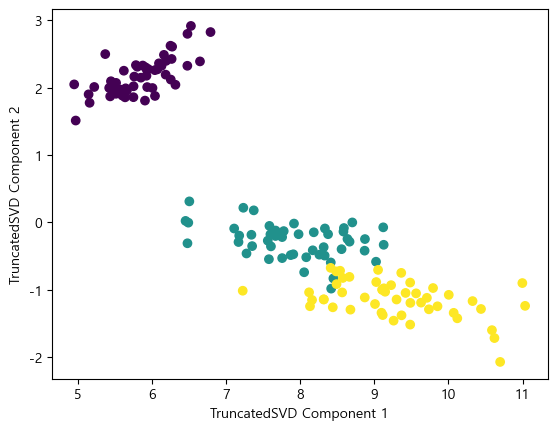

In [38]:
from sklearn.decomposition import TruncatedSVD
iris = load_iris()

# TruncatedSVD 변환
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(iris.data)
iris_tsvd = tsvd.transform(iris.data)

# 품종은 색깔로 구분
plt.scatter(x=iris_tsvd[:,0], y=iris_tsvd[:,1], c=iris.target)
plt.xlabel('TruncatedSVD Component 1')
plt.ylabel('TruncatedSVD Component 2')

Text(0.5, 1.0, 'PCA Transformed')

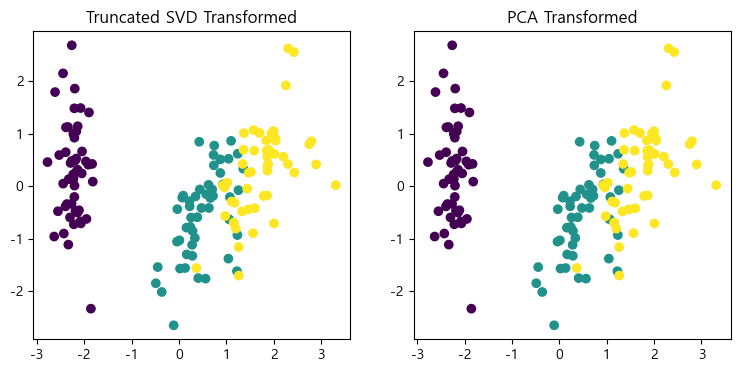

In [39]:
# 붓꽃 데이터를 StandardScaler로 변환
# 스케일링으로 데이터 세트의 중심이 동일해지면(평균0 표준편차1), 
# SVD와 PCA는 동일한 변환을 수행
scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris.data)

# TruncatedSVD 변환
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(iris_scaled)
iris_tsvd = tsvd.transform(iris_scaled)

# PCA 변환 
pca = PCA(n_components=2)
pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)

# 스캐터플랏
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
ax1.scatter(x=iris_tsvd[:,0], y=iris_tsvd[:,1], c=iris.target)
ax2.scatter(x=iris_pca[:,0], y=iris_pca[:,1], c=iris.target)

ax1.set_title('Truncated SVD Transformed')
ax2.set_title('PCA Transformed')

In [46]:
print(f'{(iris_pca - iris_tsvd).mean()}')
# 두 분해 결과행렬의 요소간 차이 평균
print(f'{(pca.components_ - tsvd.components_).mean()}')
# 두 분해 컴포넌트 행렬 간의 차이 평균

2.339702505812132e-15
-1.2576745200831851e-17


### NMF(non-negative matrix factorization)
- 기계 학습 및 데이터 마이닝에서 자주 사용되는 차원 감소 기술입니다. PCA(Principal Component Analysis) 및 SVD(Singular Value Decomposition)와 비슷하지만 모든 요소가 음수가 아니어야 한다는 제약이 있습니다.

- NMF의 핵심 아이디어는 원본 데이터 매트릭스를 음수가 아닌 두 개의 매트릭스로 분해하여 원본 데이터의 필수 기능을 캡처하지만 차원을 축소하는 것입니다.

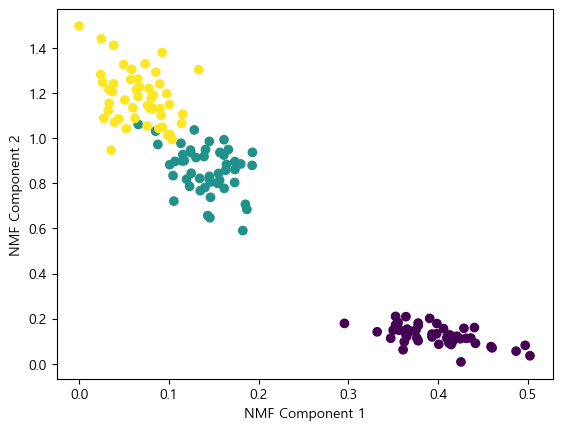

In [50]:
from sklearn.decomposition import NMF
iris = load_iris()

nmf = NMF(n_components=2)
nmf.fit(iris.data)
iris_nmf = nmf.transform(iris.data)

plt.scatter(x=iris_nmf[:,0], y=iris_nmf[:,1], c=iris.target)
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.show()

### SVD vs. NMF

- 수학적 공식:

    - SVD: Singular Value Decomposition은 행렬을 U, Σ 및 V^T의 세 가지 개별 행렬로 분해합니다. 행렬 Σ는 양수, 0 또는 음수일 수 있는 특이값을 포함
    - NMF: 음수가 아닌 행렬을 두 개의 음수가 아닌 행렬(W, H)로 분해. NMF는 텍스트 데이터 또는 스펙트로그램과 같이 데이터에 "음수가 아닌" 제약 조건이 있는 응용 프로그램에 적합

- 해석 가능성:

    - SVD: SVD는 인수분해 행렬에 제약을 두지 않으며 양수 요소와 음수 요소를 모두 허용하여 SVD를 통해 추출된 요인의 해석은 요인 요소의 기호가 의미에 영향을 줄 수 있으므로 더 어려울 수 있다.
    - NMF: NMF의 비음성 제약은 향상된 해석성을 제공. NMF가 일반적으로 사용되는 주제 모델링과 같은 응용 프로그램에서 부정적이지 않은 요소는 종종 더 직관적이고 의미 있는 해석이 가능

- 활용:

    - SVD: SVD는 이미지 압축, 협업 필터링 및 차원 감소를 포함하여 광범위한 응용 프로그램을 가지고 있어서 기능 간의 양의 상관 관계와 음의 상관 관계를 모두 캡처하는 것이 중요할 때 특히 유용
    - NMF: NMF는 텍스트 마이닝, 이미지 처리, 오디오 신호 처리 및 생물 정보학에서 음수가 아닌 데이터를 처리할 때와 요인의 해석 가능성이 필요할 때 유용

SVD와 NMF는 둘 다 유용한 행렬 분해 기법이지만 SVD는 양수 및 음수 값을 처리할 수 있고 응용 범위가 더 넓은 반면 NMF는 음수가 아닌 데이터용으로 특별히 설계되었으며 향상된 해석성을 제공. 두 기술 중 선택은 데이터의 특성, 문제의 특정 요구 사항 및 추출된 요소의 원하는 해석 가능성에 따라 달라진다.

### 차원축소 모델 비교
- PCA: 정방행렬(m * m), 공분산, 고유값, 고유벡터
- LDV: 클래스 간 분산, 클래스 내 분산 (내부 분산은 줄이고, 각 클래스간 분산은 최대로 표현)
- SVD: m * n, 행렬을 3가지 개별 행렬(U, Σ, V^T)로 분해 (Σ는 양수/0/음수일 수 있는 특이값을 포함)
- NMF: 음수가 아닌 행렬을 2개의 음수가 아닌 행렬(W, H)로 분해 (두 행렬 모두 음수가 아닌 요소로 구성)

### 붓꽃 데이터 셋에 LDA 적용하기 

In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

iris = load_iris()
iris_scaled = StandardScaler().fit_transform(iris.data)

In [2]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(iris_scaled, iris.target)
iris_lda = lda.transform(iris_scaled)
print(iris_lda.shape)

(150, 2)


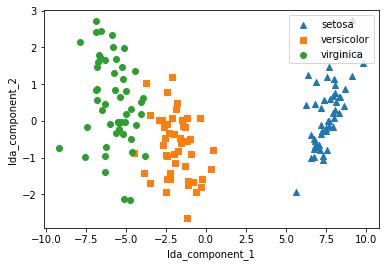

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

lda_columns=['lda_component_1','lda_component_2']
irisDF_lda = pd.DataFrame(iris_lda,columns=lda_columns)
irisDF_lda['target']=iris.target

#setosa는 세모, versicolor는 네모, virginica는 동그라미로 표현
markers=['^', 's', 'o']

#setosa의 target 값은 0, versicolor는 1, virginica는 2. 각 target 별로 다른 shape으로 scatter plot
for i, marker in enumerate(markers):
    x_axis_data = irisDF_lda[irisDF_lda['target']==i]['lda_component_1']
    y_axis_data = irisDF_lda[irisDF_lda['target']==i]['lda_component_2']

    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend(loc='upper right')
plt.xlabel('lda_component_1')
plt.ylabel('lda_component_2')
plt.show()


## 6-4 SVD

### SVD 개요

In [1]:
# numpy의 svd 모듈 import
import numpy as np
from numpy.linalg import svd

# 4X4 Random 행렬 a 생성 
np.random.seed(121)
a = np.random.randn(4,4)
print(np.round(a, 3))

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]


In [2]:
U, Sigma, Vt = svd(a)
print(U.shape, Sigma.shape, Vt.shape)
print('U matrix:\n',np.round(U, 3))
print('Sigma Value:\n',np.round(Sigma, 3))
print('V transpose matrix:\n',np.round(Vt, 3))

(4, 4) (4,) (4, 4)
U matrix:
 [[-0.079 -0.318  0.867  0.376]
 [ 0.383  0.787  0.12   0.469]
 [ 0.656  0.022  0.357 -0.664]
 [ 0.645 -0.529 -0.328  0.444]]
Sigma Value:
 [3.423 2.023 0.463 0.079]
V transpose matrix:
 [[ 0.041  0.224  0.786 -0.574]
 [-0.2    0.562  0.37   0.712]
 [-0.778  0.395 -0.333 -0.357]
 [-0.593 -0.692  0.366  0.189]]


In [3]:
# Sima를 다시 0 을 포함한 대칭행렬로 변환
Sigma_mat = np.diag(Sigma)
a_ = np.dot(np.dot(U, Sigma_mat), Vt)
print(np.round(a_, 3))

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]


In [4]:
a[2] = a[0] + a[1]
a[3] = a[0]
print(np.round(a,3))

[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.542  0.899  1.041 -0.073]
 [-0.212 -0.285 -0.574 -0.44 ]]


In [5]:
# 다시 SVD를 수행하여 Sigma 값 확인 
U, Sigma, Vt = svd(a)
print(U.shape, Sigma.shape, Vt.shape)
print('Sigma Value:\n',np.round(Sigma,3))

(4, 4) (4,) (4, 4)
Sigma Value:
 [2.663 0.807 0.    0.   ]


In [6]:
# U 행렬의 경우는 Sigma와 내적을 수행하므로 Sigma의 앞 2행에 대응되는 앞 2열만 추출
U_ = U[:, :2]
Sigma_ = np.diag(Sigma[:2])
# V 전치 행렬의 경우는 앞 2행만 추출
Vt_ = Vt[:2]
print(U_.shape, Sigma_.shape, Vt_.shape)
# U, Sigma, Vt의 내적을 수행하며, 다시 원본 행렬 복원
a_ = np.dot(np.dot(U_,Sigma_), Vt_)
print(np.round(a_, 3))

(4, 2) (2, 2) (2, 4)
[[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.542  0.899  1.041 -0.073]
 [-0.212 -0.285 -0.574 -0.44 ]]


* Truncated SVD 를 이용한 행렬 분해

In [7]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.linalg import svd

# 원본 행렬을 출력하고, SVD를 적용할 경우 U, Sigma, Vt 의 차원 확인 
np.random.seed(121)
matrix = np.random.random((6, 6))
print('원본 행렬:\n',matrix)
U, Sigma, Vt = svd(matrix, full_matrices=False)
print('\n분해 행렬 차원:',U.shape, Sigma.shape, Vt.shape)
print('\nSigma값 행렬:', Sigma)

# Truncated SVD로 Sigma 행렬의 특이값을 4개로 하여 Truncated SVD 수행. 
num_components = 4
U_tr, Sigma_tr, Vt_tr = svds(matrix, k=num_components)
print('\nTruncated SVD 분해 행렬 차원:',U_tr.shape, Sigma_tr.shape, Vt_tr.shape)
print('\nTruncated SVD Sigma값 행렬:', Sigma_tr)
matrix_tr = np.dot(np.dot(U_tr,np.diag(Sigma_tr)), Vt_tr)  # output of TruncatedSVD

print('\nTruncated SVD로 분해 후 복원 행렬:\n', matrix_tr)

원본 행렬:
 [[0.11133083 0.21076757 0.23296249 0.15194456 0.83017814 0.40791941]
 [0.5557906  0.74552394 0.24849976 0.9686594  0.95268418 0.48984885]
 [0.01829731 0.85760612 0.40493829 0.62247394 0.29537149 0.92958852]
 [0.4056155  0.56730065 0.24575605 0.22573721 0.03827786 0.58098021]
 [0.82925331 0.77326256 0.94693849 0.73632338 0.67328275 0.74517176]
 [0.51161442 0.46920965 0.6439515  0.82081228 0.14548493 0.01806415]]

분해 행렬 차원: (6, 6) (6,) (6, 6)

Sigma값 행렬: [3.2535007  0.88116505 0.83865238 0.55463089 0.35834824 0.0349925 ]

Truncated SVD 분해 행렬 차원: (6, 4) (4,) (4, 6)

Truncated SVD Sigma값 행렬: [0.55463089 0.83865238 0.88116505 3.2535007 ]

Truncated SVD로 분해 후 복원 행렬:
 [[0.19222941 0.21792946 0.15951023 0.14084013 0.81641405 0.42533093]
 [0.44874275 0.72204422 0.34594106 0.99148577 0.96866325 0.4754868 ]
 [0.12656662 0.88860729 0.30625735 0.59517439 0.28036734 0.93961948]
 [0.23989012 0.51026588 0.39697353 0.27308905 0.05971563 0.57156395]
 [0.83806144 0.78847467 0.93868685 0.72673231 

### 사이킷런 TruncatedSVD 클래스를 이용한 변환

Text(0, 0.5, 'TruncatedSVD Component 2')

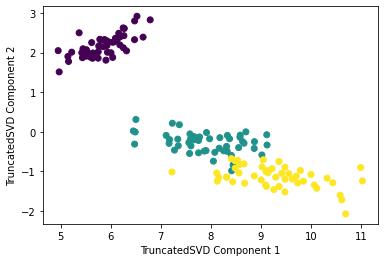

In [12]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

iris = load_iris()
iris_ftrs = iris.data
# 2개의 주요 component로 TruncatedSVD 변환
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(iris_ftrs)
iris_tsvd = tsvd.transform(iris_ftrs)

# Scatter plot 2차원으로 TruncatedSVD 변환 된 데이터 표현. 품종은 색깔로 구분
plt.scatter(x=iris_tsvd[:,0], y= iris_tsvd[:,1], c= iris.target)
plt.xlabel('TruncatedSVD Component 1')
plt.ylabel('TruncatedSVD Component 2')

Text(0.5, 1.0, 'PCA Transformed')

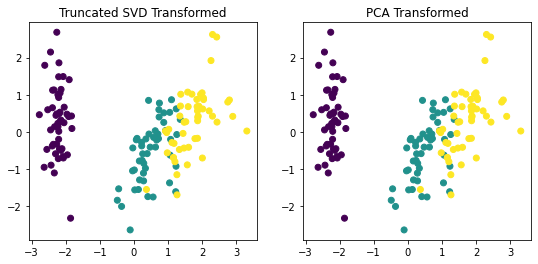

In [13]:
from sklearn.preprocessing import StandardScaler

# 붓꽃 데이터를 StandardScaler로 변환
scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris_ftrs)

# 스케일링된 데이터를 기반으로 TruncatedSVD 변환 수행 
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(iris_scaled)
iris_tsvd = tsvd.transform(iris_scaled)

# 스케일링된 데이터를 기반으로 PCA 변환 수행 
pca = PCA(n_components=2)
pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)

# TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
ax1.scatter(x=iris_tsvd[:,0], y= iris_tsvd[:,1], c= iris.target)
ax2.scatter(x=iris_pca[:,0], y= iris_pca[:,1], c= iris.target)
ax1.set_title('Truncated SVD Transformed')
ax2.set_title('PCA Transformed')

In [14]:
print((iris_pca - iris_tsvd).mean())
print((pca.components_ - tsvd.components_).mean())

2.3306703789138793e-15
-6.245004513516506e-17


## 6-4 NMF

### NMF 

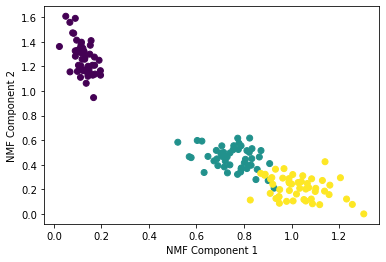

In [16]:
from sklearn.decomposition import NMF
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
iris_ftrs = iris.data
nmf = NMF(n_components=2)
nmf.fit(iris_ftrs)
iris_nmf = nmf.transform(iris_ftrs)
plt.scatter(x=iris_nmf[:,0], y= iris_nmf[:,1], c= iris.target)
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')

plt.show()
